In [1]:
!pip3 install -I  matplotlib pandas wordcloud

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached matplotlib-3.5.1-cp39-cp39-macosx_10_9_x86_64.whl (7.3 MB)
  Using cached pandas-1.3.5-cp39-cp39-macosx_10_9_x86_64.whl (11.3 MB)
  Using cached wordcloud-1.8.1-cp39-cp39-macosx_11_0_x86_64.whl
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.0.6-py3-none-any.whl (97 kB)
  Using cached fonttools-4.28.5-py3-none-any.whl (890 kB)
  Using cached kiwisolver-1.3.2-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
  Using cached numpy-1.21.5-cp39-cp39-macosx_10_9_x86_64.whl (17.0 MB)
  Using cached Pillow-8.4.0-cp39-cp39-macosx_10_10_x86_64.whl (3.0 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pytz-2021.

In [2]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("Spark NLP").master("local[4]").config("spark.driver.memory","12G").config("spark.driver.maxResultSize", "0").config("spark.kryoserializer.buffer.max", "2000M").config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext

:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/user/.ivy2/cache
The jars for the packages stored in: /Users/user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-323bbb95-3b47-47a1-bde8-fd096586fe86;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok

In [3]:
schema = StructType([
    StructField("vid", StringType(), True),
    StructField("text", StringType(), True),
    StructField("likes", IntegerType(), True),
])

df_comments_base = spark.read.schema(schema).format("csv").option("header",True).option("encoding", "utf-8").load("./comments.csv")
df_comments_base.show()

+-----------+--------------------+-----+
|        vid|                text|likes|
+-----------+--------------------+-----+
|HlEFrbLeDks|I&#39;m vaccine a...|    1|
|HlEFrbLeDks|Hi from the futur...|    1|
|HlEFrbLeDks|He will always be...|    0|
|HlEFrbLeDks|I remember watchi...|    0|
|HlEFrbLeDks|Introverts were l...|    4|
|HlEFrbLeDks|         Good times.|    0|
|HlEFrbLeDks|The beginning of ...|    3|
|HlEFrbLeDks|This must never h...|    0|
|HlEFrbLeDks|Watching this a y...|    2|
|HlEFrbLeDks|One year on and I...|    0|
|HlEFrbLeDks|I didnt mind stay...|    2|
|HlEFrbLeDks|Tomorrow marks on...|    3|
|HlEFrbLeDks|Can’t believe it’...|    7|
|HlEFrbLeDks|This was the wors...|    1|
|HlEFrbLeDks|here we are lockd...|    0|
|HlEFrbLeDks|The day it all we...|    5|
|HlEFrbLeDks|What happens if i...|    1|
|HlEFrbLeDks|  This is soo COOOOL|    0|
|HlEFrbLeDks|Interesting to re...|    2|
|HlEFrbLeDks|9 months later an...|    1|
+-----------+--------------------+-----+
only showing top

In [4]:
df_comments_base = df_comments_base.filter(col("likes") >= 0)
df_comments_base = df_comments_base.withColumn("rank", row_number().over(Window.partitionBy(col("vid")).orderBy(desc(col("likes"))))).filter(col("rank") <= 20)
df_comments_base.show()

+-----------+--------------------+-----+----+
|        vid|                text|likes|rank|
+-----------+--------------------+-----+----+
|LyiUHxD3S8s|Six brain cells i...|  156|   1|
|LyiUHxD3S8s|It&#39;s not maki...|  135|   2|
|LyiUHxD3S8s|The snitches shou...|   81|   3|
|LyiUHxD3S8s|Soo everyone arou...|   78|   4|
|LyiUHxD3S8s|If you are the so...|   76|   5|
|LyiUHxD3S8s|making it up as w...|   71|   6|
|LyiUHxD3S8s|Fake news<br>Gove...|   67|   7|
|LyiUHxD3S8s|0.1% death rate o...|   47|   8|
|LyiUHxD3S8s|It&#39;s simple, ...|   39|   9|
|LyiUHxD3S8s|And Grouse shoote...|   31|  10|
|LyiUHxD3S8s|&quot;People shou...|   26|  11|
|LyiUHxD3S8s|Anyone noticed ho...|   25|  12|
|LyiUHxD3S8s|There&#39;s six o...|   24|  13|
|LyiUHxD3S8s|Bollocks to the g...|   23|  14|
|LyiUHxD3S8s|Clearly &quot;The...|   18|  15|
|LyiUHxD3S8s|make your voice h...|   15|  16|
|LyiUHxD3S8s|Unless you&#39;re...|   13|  17|
|LyiUHxD3S8s|Another power tri...|   13|  18|
|LyiUHxD3S8s|I&#39;ve got a ch...|

In [5]:
vschema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True)
])

df_bbc = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/BBC_videos_final.csv")
df_bbc = df_bbc.select(col("videoId"), col("year"), col("month"), col("day"))
df_bbc = df_bbc.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("BBC"))

df_guardian = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Guardian_videos_final.csv")
df_guardian = df_guardian.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_guardian = df_guardian.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Guardian"))

special_schema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
])
df_dailymail = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/DailyMail_videos_final.csv")
df_dailymail = df_dailymail.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_dailymail = df_dailymail.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("DailyMail"))

df_independent = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Independent_videos_final.csv")
df_independent = df_independent.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_independent = df_independent.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Independent"))

df_sun = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/SUN_videos_final.csv")
df_sun = df_sun.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_sun = df_sun.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("SUN"))

In [6]:
df_media = df_bbc.unionAll(df_guardian).unionAll(df_dailymail).unionAll(df_independent).unionAll(df_sun)
df_comments = df_comments_base.join(df_media, on = (col("videoId") == col("vid"))).select(col("text"), col("Date").alias("date"), col("from"))

# LDA
## data processing

In [7]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.annotator import LemmatizerModel

documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized")
stopwordsRemoval = StopWordsCleaner().setInputCols("normalized").setOutputCol("cleanTokens").setCaseSensitive(False)
lemmatizer = LemmatizerModel.pretrained().setInputCols(['cleanTokens']).setOutputCol('lemmatized')
finisher = Finisher().setInputCols(["lemmatized"]).setOutputCols(["tokens"]).setOutputAsArray(True).setCleanAnnotations(False)

pipeline = Pipeline(
    stages=[documentAssembler,
            tokenizer,
            normalizer,
            stopwordsRemoval,
            lemmatizer,
            finisher])

preprocessModel = pipeline.fit(df_comments)
resultDf  = preprocessModel.transform(df_comments)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


In [8]:
tokensDf = resultDf.select('text','date','from','tokens')

independtComments = tokensDf.filter(tokensDf["from"] == "Independent")
bbcComments = tokensDf.filter(tokensDf["from"] == "BBC")
dailymailComments = tokensDf.filter(tokensDf["from"] == "DailyMail")
theSunComments = tokensDf.filter(tokensDf["from"] == "SUN")
guardianComments = tokensDf.filter(tokensDf["from"] == "Guardian")

## LDA process

In [9]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
def getTopicsByLda(df,title):
    countVectorizer = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=500, minDF=3.0)
    countVectorizerModel = countVectorizer.fit(df)
    vectorizedTokens = countVectorizerModel.transform(df)

    numTopics = 100
    maxIter = 500
    lda = LDA(k=numTopics, maxIter=maxIter)
    model = lda.fit(vectorizedTokens)

    vocab = countVectorizerModel.vocabulary
    topics = model.describeTopics()

    topicsRdd = topics.rdd
    topicsWords = topicsRdd.map(lambda row: row['termIndices']).map(lambda indexList: vocab[indexList[0]]).collect()

    generateWordCloud((" ").join(topicsWords),title)


## generate word cloud

In [29]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
def generateWordCloud(text,title):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()
    print(text)

21/12/22 19:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:00 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:05 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:07 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:08 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 19:12:12 WAR

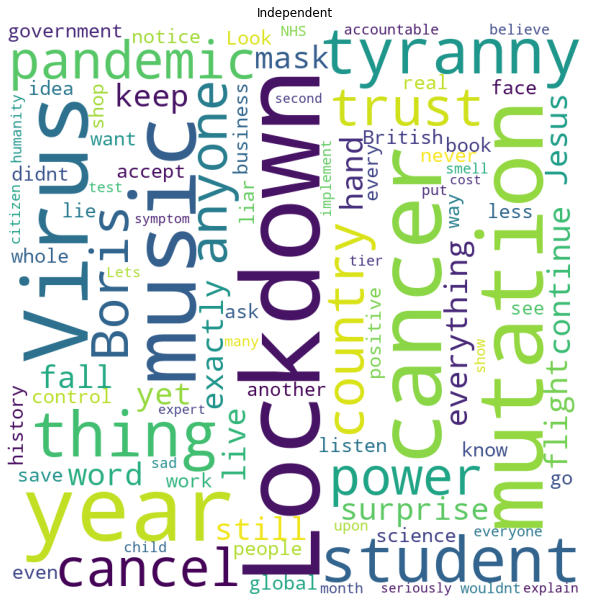

tyranny student cancer thing pandemic power cancel mutation do Virus trust country Boris anyone surprise Lockdown fall word year continue everything Lockdown exactly cancer keep flight mask still like hand yet live Jesus government less Look accept book listen control want didnt never know virus also British idea whole notice music way go real lockdown global science people even save history ask positive lie work every liar face business shop another see everyone believe implement Lets humanity show test many citizen upon wouldnt sad mutation NHS put year month child music accountable tier smell seriously cost expert second symptom explain


In [30]:
getTopicsByLda(independtComments,"Independent")

21/12/22 17:09:48 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:02 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:11 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:14 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:15 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB
21/12/22 17:10:16 WAR

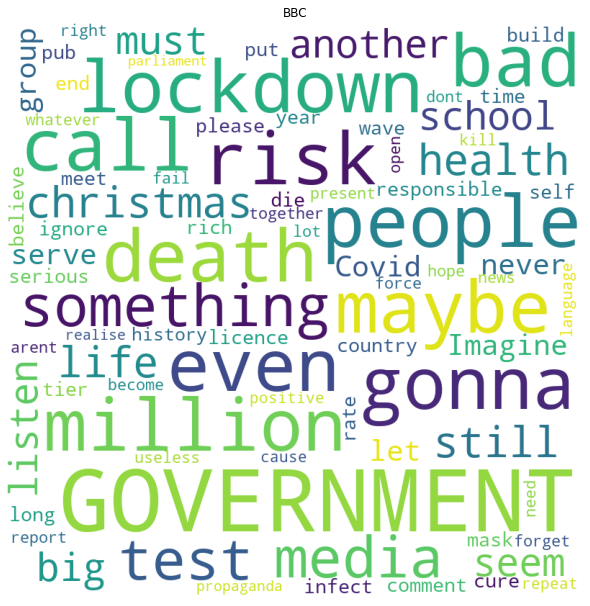

In [12]:
getTopicsByLda(bbcComments,"BBC")

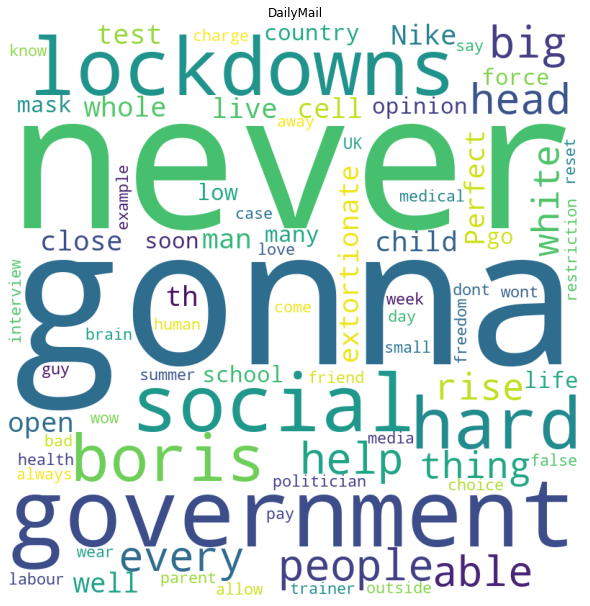

In [13]:
getTopicsByLda(dailymailComments,"DailyMail")

21/12/22 17:33:35 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:39 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:49 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:33:51 WAR

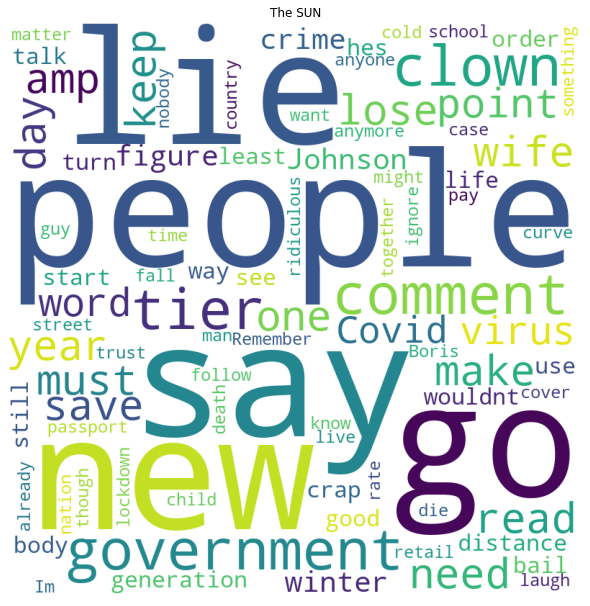

In [14]:
getTopicsByLda(theSunComments,"The SUN")

21/12/22 17:43:53 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:54 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:56 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:57 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:44:01 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB
21/12/22 17:44:04 WAR

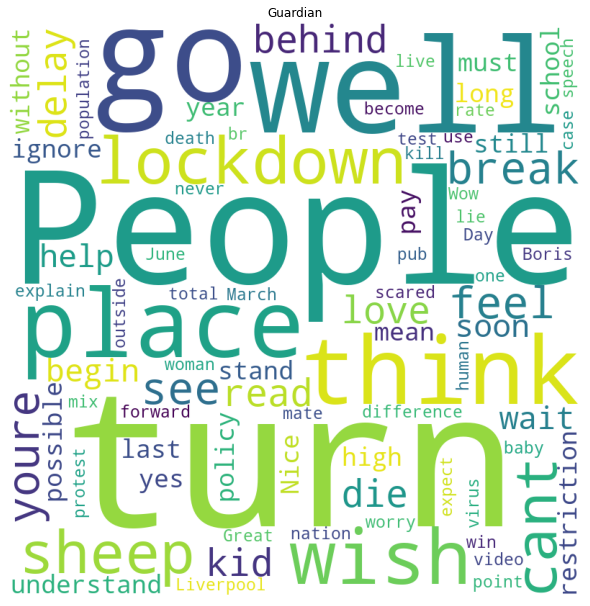

In [15]:
getTopicsByLda(guardianComments,"Guardian")